In [1]:
# Model functions from keras
from keras.layers import Input
from keras.models import Model, load_model
from keras.optimizers import Adam

# numpy for some mathematical operations
import numpy as np
import matplotlib.pyplot as plt

# Custom functions
from utils.gan_func import build_discriminator
from utils.gan_func import build_generator
from utils.gan_func import get_random_noise
from utils.gan_func import get_training_data
from utils.gan_func import save_images

In [2]:
# To avoid GPU memory issues

import tensorflow as tf
print(tf.test.gpu_device_name())

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/device:GPU:0


In [3]:
# Data Parameters
imgs_dir = 'data'

image_height, image_width, channels = 64, 64, 3
image_shape = (image_width, image_height, channels)

random_noise_dimension = 100
rows, columns = 4, 8

save_images_interval = 100

target_dir = 'generated_faces'

target_fn = "/generated"

# Model parameters

use_pretrained_model = False

pretrained_model_path_generator = "saved_models/face_generator.h5"
pretrained_model_path_discriminator = "saved_models/face_discriminator.h5"

epochs = 5000
batch_size = 32

start_epoch = 0
if use_pretrained_model:
    assert (start_epoch == 0)


In [4]:
d_losses=[]
d_acc=[]
g_losses=[]

In [10]:
alpha, dropout, mean = 0.0, 0.0, 0.80
optimizer = Adam(0.0002, 0.5)

In [11]:
# Get the real images
training_data = get_training_data.get_training_data(imgs_dir, image_width, image_height, channels)

# Map all values to a range between -1 and 1.
training_data = training_data / 127.5 - 1.

# =============================================================================
# Set up the labels for generated and real images
# =============================================================================

# Two arrays of labels. Labels for real images: [1,1,1 ... 1,1,1], 
# labels for generated images: [0,0,0 ... 0,0,0]
labels_for_real_images = np.ones((batch_size, 1)) - 0.15
labels_for_generated_images = np.zeros((batch_size, 1))

  1%|▏         | 104/7864 [00:00<00:07, 1033.95it/s]

Loading training data...


100%|██████████| 7864/7864 [00:07<00:00, 1090.48it/s]


In [12]:
if use_pretrained_model:
    generator     = load_model(pretrained_model_path_generator)
    discriminator = load_model(pretrained_model_path_discriminator)
else:
    generator = build_generator.build_generator(random_noise_dimension, channels, alpha=alpha, mean=mean)
    discriminator = build_discriminator.build_discriminator(image_shape, alpha=alpha, dropout=dropout, mean=mean)

discriminator.compile(loss="binary_crossentropy",
                      optimizer=optimizer,
                      metrics=["accuracy"])

# Set up the actual GAN (= combined_model)
random_input = Input(shape=(random_noise_dimension,))
generated_image = generator(random_input)
discriminator.trainable = False
validity = discriminator(generated_image)
combined_model = Model(random_input, validity)  # This is the actual GAN

combined_model.compile(loss="binary_crossentropy",
                       optimizer=optimizer)

In [13]:
# =============================================================================
# Train GAN
# =============================================================================

for epoch in range(epochs):
        # Select a random batch of real images
    indices = np.random.randint(0, training_data.shape[0], batch_size)
    real_images = training_data[indices]

        # Generate random noise for a whole batch.
    random_noise = get_random_noise.get_random_noise(rows, columns, random_noise_dimension)

    discriminator.trainable = True

        # Generate a batch of new images.
    generated_images = generator.predict(random_noise)

        # Train the discriminator on real images.
    discriminator_loss_real = discriminator.train_on_batch(real_images, labels_for_real_images)
        # Train the discriminator on generated images.
    discriminator_loss_generated = discriminator.train_on_batch(generated_images, labels_for_generated_images)
        # Calculate the average discriminator loss.
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_generated)

        # Train the generator using the combined model. Generator tries to trick 
        # discriminator into mistaking generated images as real.
    discriminator.trainable = False

    labels_for_tricking_discriminator = np.ones((batch_size, 1))
    generator_loss = combined_model.train_on_batch(random_noise, labels_for_tricking_discriminator)

        # Training ends above (one iteration) 
        # This is only for display and saving models
    if epoch % save_images_interval == 0:
        save_images.save_images(epoch, random_noise_dimension, generator, target_dir, target_fn, start_epoch)
        print("%4d [Discriminator loss: %f, acc.: %2.2f%%] [Generator loss: %f]" %
              (epoch, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))
    d_losses.append(discriminator_loss[0])
    d_acc.append(discriminator_loss[1])
    g_losses.append(generator_loss)

    
        # Save the model for a later use
    generator.save(pretrained_model_path_generator)
    discriminator.save(pretrained_model_path_discriminator)


   0 [Discriminator loss: 3.097282, acc.: 0.00%] [Generator loss: 0.682393]
 100 [Discriminator loss: 0.327767, acc.: 50.00%] [Generator loss: 0.216515]
 200 [Discriminator loss: 0.218223, acc.: 50.00%] [Generator loss: 0.020845]
 300 [Discriminator loss: 0.276810, acc.: 50.00%] [Generator loss: 0.044565]
 400 [Discriminator loss: 0.231908, acc.: 50.00%] [Generator loss: 0.035560]
 500 [Discriminator loss: 0.241407, acc.: 50.00%] [Generator loss: 0.050487]
 600 [Discriminator loss: 0.221750, acc.: 50.00%] [Generator loss: 0.014506]
 700 [Discriminator loss: 0.217790, acc.: 50.00%] [Generator loss: 0.023544]
 800 [Discriminator loss: 0.246386, acc.: 50.00%] [Generator loss: 0.027375]
 900 [Discriminator loss: 0.233137, acc.: 50.00%] [Generator loss: 0.019760]
1000 [Discriminator loss: 0.231221, acc.: 50.00%] [Generator loss: 0.059520]
1100 [Discriminator loss: 0.225069, acc.: 50.00%] [Generator loss: 0.041047]
1200 [Discriminator loss: 0.222907, acc.: 50.00%] [Generator loss: 0.016738]


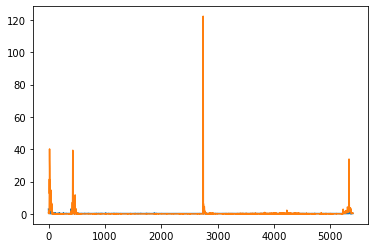

In [14]:
plt.plot(d_losses)
# plt.plot(d_acc)
plt.plot(g_losses)
plt.show()